In [ ]:
import numpy as np
import os
import PIL
import pandas as pd
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
from keras.callbacks import CSVLogger
from matplotlib import pyplot as plt

In [ ]:
data_dir = pathlib.Path('drive/MyDrive/fig/dataset_12000')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
batch_size = 64
img_height = 128
img_width = 128

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 24000 files belonging to 2 classes.
Using 19200 files for training.
Found 24000 files belonging to 2 classes.
Using 4800 files for validation.


In [ ]:

model = tf.keras.Sequential([
  
  tf.keras.Input(shape=(img_height, img_width, 3)),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),

  # Block 1
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
  tf.keras.layers.MaxPooling2D((2,2)),

  # Block 2
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
  tf.keras.layers.MaxPooling2D((2,2)),

  # Block 3
  tf.keras.layers.Conv2D(256, (5, 5), activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
  tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
  tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
  tf.keras.layers.MaxPooling2D((2,2)),

  # Flatten
  tf.keras.layers.Flatten(),

  # Fully connected layers
  tf.keras.layers.Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
  tf.keras.layers.Dropout(.2),
  tf.keras.layers.Dense(256, activation='relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
  tf.keras.layers.Dropout(.2),
  tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
  tf.keras.layers.Dropout(.2),
  tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
  tf.keras.layers.Dropout(.2),
  tf.keras.layers.Dense(1, activation='sigmoid')
])
    

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 256)       819456    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 256)       5

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    patience=15
)

In [ ]:
path = 'drive/MyDrive/fig/CNN-2'

In [ ]:
csv_logger = CSVLogger(path+'/history.csv', append=True)

In [ ]:
try:
  os.remove(path+'/tmp')
except:
  checkpoint_filepath = path+'/tmp/checkpoint'
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=True,
      monitor='val_loss',
      mode='min',
      save_freq="epoch",
      save_best_only=True)

In [ ]:
try:
  model.load_weights(checkpoint_filepath)
except:
  pass

In [ ]:
#with tf.device('/device:GPU:0'):
with tf.device('/device:GPU:0'):
  history = model.fit(
      train_ds, 
      validation_data=val_ds, 
      epochs=1000, 
      callbacks=[early_stopping, csv_logger, model_checkpoint_callback])

Epoch 1/1000
600/600 [==============================] - 2332s 4s/step - loss: 0.9575 - accuracy: 0.7670 - val_loss: 0.6029 - val_accuracy: 0.8906
Epoch 2/1000
600/600 [==============================] - 60s 100ms/step - loss: 0.5405 - accuracy: 0.9027 - val_loss: 0.4708 - val_accuracy: 0.9260
Epoch 3/1000
600/600 [==============================] - 62s 102ms/step - loss: 0.4255 - accuracy: 0.9319 - val_loss: 0.3527 - val_accuracy: 0.9515
Epoch 4/1000
600/600 [==============================] - 60s 99ms/step - loss: 0.3439 - accuracy: 0.9506 - val_loss: 0.3419 - val_accuracy: 0.9435
Epoch 5/1000
600/600 [==============================] - 66s 109ms/step - loss: 0.3001 - accuracy: 0.9599 - val_loss: 0.2990 - val_accuracy: 0.9583
Epoch 6/1000
600/600 [==============================] - 66s 108ms/step - loss: 0.2682 - accuracy: 0.9654 - val_loss: 0.2497 - val_accuracy: 0.9694
Epoch 7/1000
600/600 [==============================] - 62s 103ms/step - loss: 0.2441 - accuracy: 0.9694 - val_loss: 0.2

In [ ]:
def plot(history, name, train, val, path):
    plt.plot(history.history[train])
    plt.plot(history.history[val])
    plt.title('loss')
    plt.xlabel('epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig(path+'/'+name+'.png')
    plt.show()

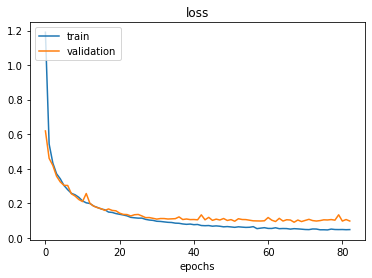

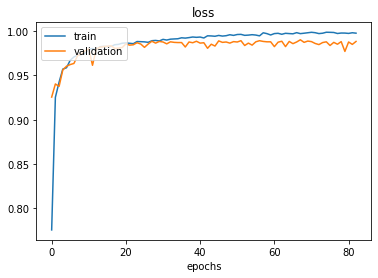

In [ ]:
plot(history, 'training_loss', 'loss', 'val_loss', path)
plot(history, 'training_accuracy', 'accuracy', 'val_accuracy', path)

In [ ]:
history = pd.read_csv(path+'/history.csv')
"""
index = list()
length = len(history)-1
for i in range(22):
  index.append(length-i)

history = history.drop(index)

history = history.tail(100)

history =  pd.DataFrame({
                   'accuracy': history['accuracy'].values.tolist(),
                   'val_accuracy': history['val_accuracy'].values.tolist(),
                   'loss': history['loss'].values.tolist(),
                   'val_loss': history['val_loss'].values.tolist()},)
"""
print(history)

    epoch  accuracy      loss  val_accuracy  val_loss
0       0  0.775781  1.190624      0.925417  0.618730
1       1  0.925156  0.542632      0.940208  0.459839
2       2  0.942292  0.432595      0.937500  0.418633
3       3  0.956979  0.370557      0.956042  0.356535
4       4  0.958490  0.341350      0.960208  0.323302
..    ...       ...       ...           ...       ...
78     78  0.997604  0.047415      0.987917  0.101569
79     79  0.997552  0.047045      0.976875  0.132673
80     80  0.997187  0.047371      0.987500  0.096317
81     81  0.997917  0.046317      0.984792  0.105255
82     82  0.997448  0.046993      0.988125  0.096593

[83 rows x 5 columns]


In [ ]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [ ]:
wb = gc.open_by_url("https://docs.google.com/spreadsheets/d/1dNn1WTCPKRWdL5bGBJ56Zxc-uvWzkrOZcrt-v2O9TXM/edit?usp=sharing")

In [ ]:
sheet = wb.worksheet('history')
data = sheet.get_all_values()
df = pd.DataFrame(data)

In [ ]:
print(df.tail(77))

      0             1             2             3             4
224   1  0.9185000062  0.2184580714  0.9359999895  0.1914585084
225   2  0.9415000081   0.172774151  0.9265000224  0.1899781227
226   3  0.9513750076  0.1390092522  0.9340000153  0.1688388288
227   4  0.9608749747  0.1168320104  0.9434999824  0.1511791199
228   5  0.9626250267  0.1094828695  0.9514999986  0.1437927186
..   ..           ...           ...           ...           ...
296  73             1      2.67E-05  0.9524999857  0.3332082331
297  74             1      2.47E-05  0.9549999833  0.3321733177
298  75             1      2.23E-05  0.9509999752  0.3395810425
299  76             1      2.22E-05  0.9520000219  0.3423304856
300  77             1      1.99E-05  0.9545000196  0.3411618471

[77 rows x 5 columns]
